# pyLINEAR: Simulation (Demo)

## By: Russell Ryan and Kornpob Bhirombhakdi

This Notebook demonstrates how to implement pyLINEAR (cite: ???) for simulating grism images from a direct image. In this demo, we assume that you have installed packages associated to pyLINEAR including i) polyclip, ii) h5axeconfig, and iii) pyLINEAR. You can download the packages from https://github.com/Russell-Ryan, and follow the instruction for the installation, and their documentation. After installing the packages (and other dependencies), please download the this Notebook's folder. We recommend using Anaconda/Python3 environment for using this Notebook as well as the pyLINEAR.

In this folder, files include:

- 01_test_pylinear_simulation.ipynb = this Notebook

- img.fits = simulated direct image. This image have two gaussian sources at physical x-y pixels about (2800,2000) and (2800,1500). We will simulate a grism image associated to this direct image.

- obs.lst = information of direct images. This is a two-column text file with space delimiter. For each row, the first column specifies a direct image file, and the second column specifies its associated telescope/filter file (*.filt file included with h5axeconfig package, which can also be found in the STScI resources). In this demo, we assume the direct image img.fits was taken from HST/WFC3-F105W. If you have more than one direct images, simply add another lines.

- sed.lst = list of SED models to be simulated. This is a three-column text file with space delimiter. The first column identifies sources ID (in integer only). The second column identifies the path to the associated SED model file (which is a space-delimited text file with two columns: wavelength (in A) and flam (in erg/s/cm^2/A). This demo will generate the SED models: sed1.dat and sed2.dat. Note that we have two sources in img.fits, therefore we provide two SED models in sed.lst. The third column specifies redshift.

- wcs.lst = list of grism orientations to be simulated. This has four columns with space delimiter. The first columnn identifies the prefix (e.g., A) to the output grism image (e.g., A_flt.fits). The second to last columns identifies the orientation of the telescope, i.e., (CRVAL1, CRVAL2) and rotation.

- defaults.yml = configuration file of pyLINEAR.

Unlike the other files provided in this folder, defaults.yml must be copied (or edited) manually to the local library of pyLINEAR, e.g., '/Users/kbhirombhakdi/anaconda2/envs/py3/lib/python3.7/site-packages/pylinear-1.0-py3.7.egg/pylinear/config/defaults.yml'. Please see ??? for details about the configuration file. Note that, as specified in the configuration file, we will simulate grism images from HST/WFC3-IR-G102 using the HST/WFC3-F105W direct image (img.fits). We will do only simulation, so make sure setting 'perform: true' and 'gzip: false' in the simuation section, and 'perform: false' in both extraction and cutout sections.

To start this demo, run this Notebook from its root.

In [1]:
from astropy.convolution import Gaussian2DKernel
from astropy.io import fits
from astropy.stats import gaussian_fwhm_to_sigma
import csv
import matplotlib.pyplot as plt
import numpy as np
import os
from photutils import detect_threshold,detect_sources
import pylinear

In [2]:
# get root directory, and remove outputs from previous run
cwd = os.getcwd() 
!rm sed1.dat 
!rm sed2.dat
!rm seg.fits
!rm A_flt.fits
!rm B_flt.fits
!rm linear.log
!rm -r TABLES

rm: A_flt.fits: No such file or directory
rm: B_flt.fits: No such file or directory


In [3]:
# generate SED models
# Note that G102 bandwidth is [7500,12500] A with resolution 25 A/pix

x = np.arange(start=7500,stop=12550,step=50) # wavelength grids with resolution 50 A/pix
y1 = np.ones(shape=x.shape) # SED model 1
y2 = np.linspace(start=10,stop=1,num=len(x)) # SED model 2

# Save SED models
with open('./sed1.dat', mode='w') as out:
    writer = csv.writer(out, delimiter=' ', quotechar='#', quoting=csv.QUOTE_MINIMAL)
    for i in np.arange(len(x)):
        writer.writerow([x[i], y1[i]])
out.close()   

with open('./sed2.dat', mode='w') as out:
    writer = csv.writer(out, delimiter=' ', quotechar='#', quoting=csv.QUOTE_MINIMAL)
    for i in np.arange(len(x)):
        writer.writerow([x[i], y2[i]])
out.close()  

In [4]:
# Create segmentation map

x = fits.open('img.fits')
data = x[0].data

threshold = detect_threshold(data,snr=2.) # identify detection threshold over background

# Create a kernel for filtering sources in the detection algorithm
# Use a 2D gaussian kernel with FWHM = 3 pix
sigma = 3. * gaussian_fwhm_to_sigma # FWHM = 3 pixels
kernel = Gaussian2DKernel(sigma,x_size=3,y_size=3) # instantiate 2D gaussian kernel
kernel.normalize() # normalization

# Detect sources
# Output as a segmentation map
segm = detect_sources(data,threshold,npixels=5,filter_kernel=kernel)

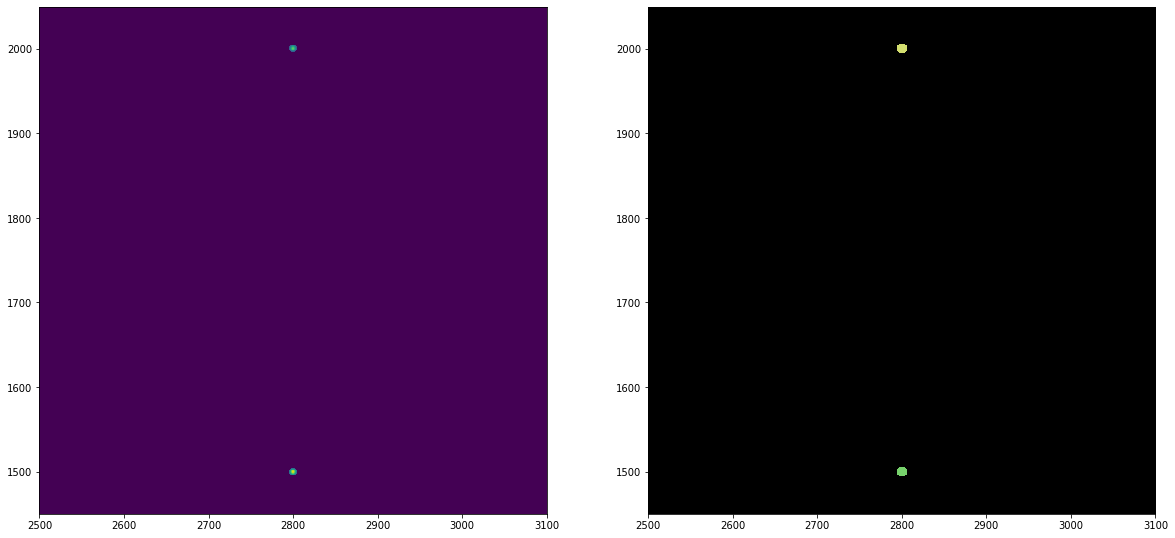

In [5]:
# Plot the direct image and segmentation map
fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(fits.open('img.fits')[0].data,origin='lower',cmap='viridis',vmin=0)
ax[1].imshow(segm,origin='lower',cmap=segm.cmap(random_state=12345))

# Set to zoom in the source region
dx = 300
dy = 300
x = 2800
y = 1750
ax[0].set_xlim(x-dx,x+dx),ax[1].set_xlim(x-dx,x+dx)
ax[0].set_ylim(y-dy,y+dy),ax[1].set_ylim(y-dy,y+dy)

plt.show()

In [6]:
# Save the segmentation map
# Note: the segmentation file must be a fits file with the direct image's header
x = fits.open('img.fits')
x[0].data = segm.data
x.writeto('seg.fits',overwrite=True)
x.close()

In the segmentation map, we see two sources with pixel values = 1 or 2 for sources, and = 0 for background. This can be easily seen by using a fits viewer like DS9. The pixel values in seg.fits are considered as the source IDs.

NOTE: recall that the first column of sed.lst specifies source IDs with their corresponding SED models. Make sure that the source IDs are mapped consistently between sed.lst and seg.fits.

In [7]:
!pylinear # running pyLINEAR



    Linear Extraction and Simulation of Slitless Spectroscopy

           by: Russell Ryan

     citation: http://adsabs.harvard.edu/abs/2018PASP..130c4501R
      version: 1.0
      contact: rryan@stsci.edu

# Configuration for pyLINEAR

cpu: &CPU
  ncpu: 1                                # number of processors to use
  verbose: True

calib: &CALIB
  h5conf: hst_wfc3_ir_beams.h5           # HDF5 file for beam info
  h5flat: Null                           # HDF5 file for flat field
  h5siaf: hst_wfc3_ir_detector.h5        # HDF5 file for detectors
tables: &TABLES
  path: TABLES/                          # relative path for the tables
  remake: True
  gzip: True                             # gzip the resulting data
  nsub: 5                                # number of intervals for TrapZ
  cpu: *CPU
                                         # import CPU settings
sources:
  segmap: seg.fits                       # segmentation map for sources
  obslst: obs.lst                        # file

pyLINEAR will output:

- A_flt.fits and B_flt.fits: these are grism images specified in wcs.lst
- linear.log: a log file
- TABLES: provides details for each grism image

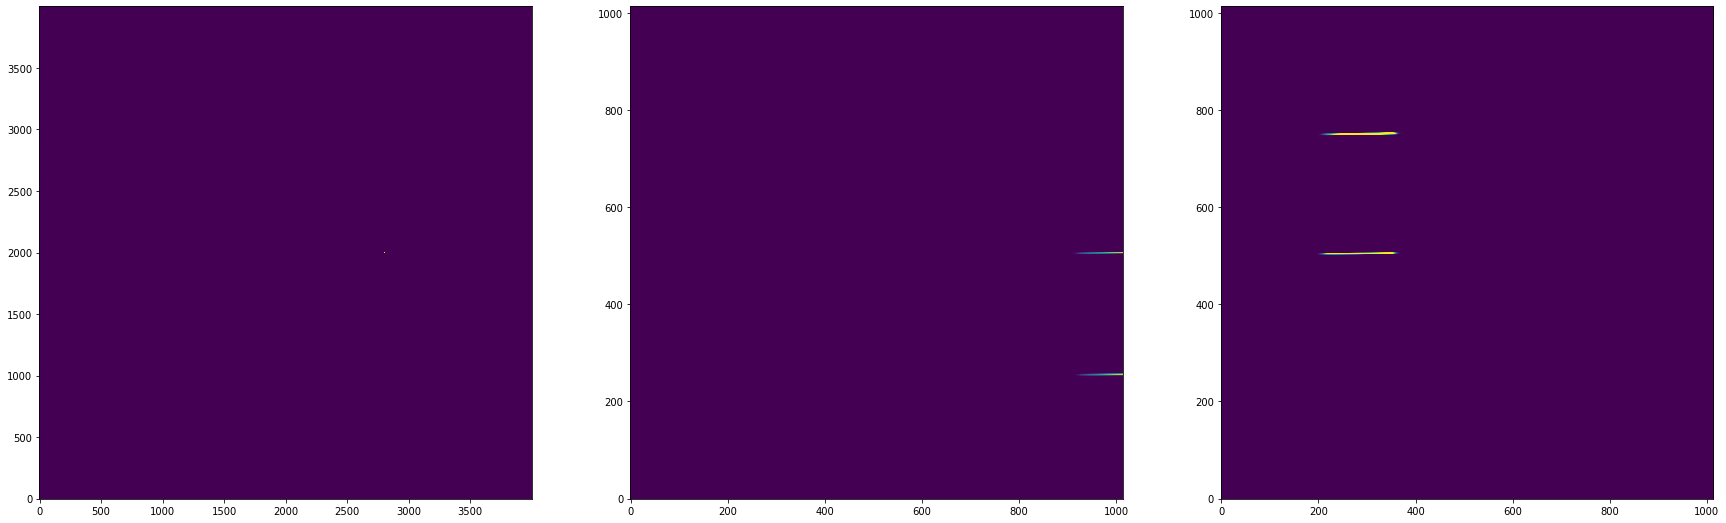

In [8]:
# Plot the direct image and two grism ones
# NOTE: showing these images with DS9, matching them with WCS, and blinking them is recommended to see how the sources are dispersed

fig,ax = plt.subplots(1,3,figsize=(30,10))

x = fits.open('img.fits')
ax[0].imshow(x[0].data,cmap='viridis',origin='lower',vmin=0,vmax=0.1)

x = fits.open('A_flt.fits')
ax[1].imshow(x['SCI'].data,cmap='viridis',origin='lower')

x = fits.open('B_flt.fits')
ax[2].imshow(x['SCI'].data,cmap='viridis',origin='lower',vmin=0,vmax=0.1)

plt.show()